In [1]:
import random
import urllib.request
import imageio as imio
from einops import rearrange
import matplotlib.pyplot as plt
from IPython.display import clear_output, HTML, display
import numpy as np

import sys
sys.path.append('..')

from models.model_utils import TrajectorySampler
from builders.builders import build_dataloader
from utils.utils import instantiate_from_config
from notebooks.walkthrough_utils import get_smooth_trajectory
from utils.camera_trajectory import rotate_n, go_forward, go_backward

import copy
from PIL import ImageDraw, Image, ImageFont
import torchvision.transforms.functional as FF

/Users/allenzhang/opt/anaconda3/envs/gsn/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from options.base_config import BaseConfig
from models.blob_maker import BlobMaker
from types import SimpleNamespace
from omegaconf import OmegaConf

layout_net_config = OmegaConf.create({
    'params': {
        'n_features_max':10,
        'spatial_style': True
    },
    'target': 'models.networks.layoutnet.LayoutGenerator'
})
blob_maker = BlobMaker(layout_net_config=layout_net_config, decoder_size_in = 16)


[Errno 2] No such file or directory: 'models/op/fused_bias_act.cpp'
There was something wrong with the CUDA kernels
Reverting to native PyTorch implementation


In [3]:
import torch
torch.seed()

device = 'cpu'
# z_dim = opt.model_config.params.decoder_config.params.z_dim
z_dim = 512
z = torch.randn(1, z_dim, device=device)

In [4]:
truncate = -1000.
blob_maker.device = device
blob_maker.get_mean_latent(100)

def draw_labels(img, layout, T, colors, layout_i=0):
    font = ImageFont.truetype('LiberationSans-Bold.ttf', 10)
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    mask = layout['sizes'][layout_i, 1:] > T
    idmap = torch.arange(len(mask))[mask]
    blob = {k: layout[k][layout_i][mask].mul(128).tolist() for k in ('xs', 'ys')}
    for i, (x, y) in enumerate(zip(blob['xs'], blob['ys'])):
        I = idmap[i]
        _, h = draw.textsize(str(I), font=font)
        w = h
        
        color = tuple(colors[I + 1].mul(255).round().int().tolist())
        draw.text((x - w / 2, y - h / 2), f'{I}', fill=color, stroke_width=1, font=font, stroke_fill=(0, 0, 0))
    return FF.to_tensor(img).permute(1, 2, 0), img


def for_canvas(img):
    return img.detach()[0].round().permute(1, 2, 0).clamp(min=0, max=255).cpu().numpy().astype(np.uint8)

Computing mean latent: 100%|██████████| 100/100 [00:02<00:00, 46.24it/s]


tensor([[0.4396, 0.4720, 0.2795, 0.6598, 0.2177, 0.3655, 0.1821, 0.4423, 0.4292,
         0.4269]])
dict_keys(['scores_pyramid', 'feature_grid', 'feature_img', 'entropy_img', 'xs', 'ys', 'covs', 'raw_scores', 'sizes', 'composed_scores', 'features'])
tensor([[ 0.1119, -0.8602,  0.6489, -1.3142,  0.3528,  1.4827,  0.5956, -0.0582,
         -0.8732,  0.0149,  1.3456]])
torch.Size([1, 3, 128, 128])
(128, 128, 3)


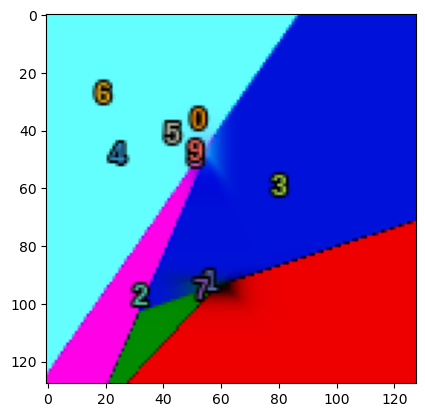

In [5]:
torch.seed()
z = torch.randn(1, z_dim, device=device)


torch.manual_seed(1)

with torch.no_grad():
    layout = blob_maker.generate_layout(z, viz = True, viz_size=[128, 128], no_jitter = True, ret_layout = True)    
    print(layout['xs'])

print(layout.keys())
print(layout['sizes'])

blob_im = layout['feature_img']
print(blob_im.shape)

blobs = for_canvas(blob_im.mul(255))
print(blobs.shape)

COLORS = torch.tensor([[0.9804, 0.9451, 0.9176], [0.8980, 0.5255, 0.0235], [0.3647, 0.4118, 0.6941], [0.3216, 0.7373, 0.6392], [0.6000, 0.7882, 0.2706], [0.1843, 0.5412, 0.7686], [0.6471, 0.6667, 0.6000], [0.8549, 0.6471, 0.1059], [0.4627, 0.3059, 0.6235], [0.8000, 0.3804, 0.6902],  [0.9294, 0.3922, 0.3529],  [0.1412, 0.4745, 0.4235],  [0.4000, 0.7725, 0.8000],  [0.9647, 0.8118, 0.4431],  [0.9725, 0.6118, 0.4549],  [0.8627, 0.6902, 0.9490],  [0.5294, 0.7725, 0.3725],  [0.6196, 0.7255, 0.9529],  [0.9961, 0.5333, 0.6941],  [0.7882, 0.8588, 0.4549], [0.5451, 0.8784, 0.6431], [0.7059, 0.5922, 0.9059], [0.7020, 0.7020, 0.7020], [0.5216, 0.3608, 0.4588], [0.8510, 0.6863, 0.4196], [0.6863, 0.3922, 0.3451], [0.4510, 0.4353, 0.2980], [0.3216, 0.4157, 0.5137], [0.3843, 0.3255, 0.4667], [0.4078, 0.5216, 0.3608], [0.6118, 0.6118, 0.3686], [0.6275, 0.3804, 0.4667], [0.5490, 0.4706, 0.3647], [0.4863, 0.4863, 0.4863]])
labeled_blobs, labeled_blobs_img = draw_labels(blobs, layout, truncate, COLORS)

plt.imshow(labeled_blobs)

In [6]:
t = torch.tensor([[[1,-1], [10, 2]]])
# i = torch.argmin(t, 1, keepdim=False)
# print(i)
# print(t)
# t[i] = 0
# print(t)
i = (t == t.max(dim=2, keepdim=True)[0])
print(i)

print(t * i)

print(torch.einsum('...ij,...j -> ...j', t*i, torch.tensor([10, 10])))

tensor([[[ True, False],
         [ True, False]]])
tensor([[[ 1,  0],
         [10,  0]]])
tensor([[110,   0]])
